<a href="https://colab.research.google.com/github/sravanisuryapeta/ML-166/blob/main/ML_Assignment66.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# (a) Load the data into memory. Make an appropriate X matrix and y vector.
import pandas as pd

# Load dataset
data = pd.read_csv("heart_disease_uci (1).csv")

# Drop unnecessary columns
data = data.drop(columns=["id", "dataset"])

# Define X (features) and y (target)
X = data.drop(columns=["num"])
y = (data["num"] > 0).astype(int)   # Convert to binary classification (0 = no disease, 1 = disease)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Target distribution:\n", y.value_counts())


Shape of X: (920, 13)
Shape of y: (920,)
Target distribution:
 num
1    509
0    411
Name: count, dtype: int64


In [ ]:
print(data.columns)


Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [ ]:
# (b) Split the data at random into 80% training + validation and 20% testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (736, 13) (736,)
Test shape: (184, 13) (184,)


In [ ]:
# ==========================
# (c) Objective of logistic regression with L2 regularization
# ==========================
# Logistic regression with L2 regularization minimizes:
#
#   J(w) = -(1/N) * Σ [ y_i log(p_i) + (1 - y_i) log(1 - p_i) ] + (λ/2) * ||w||^2
#
# where p_i = sigmoid(w^T x_i)
# λ ≥ 0 is the regularization strength.


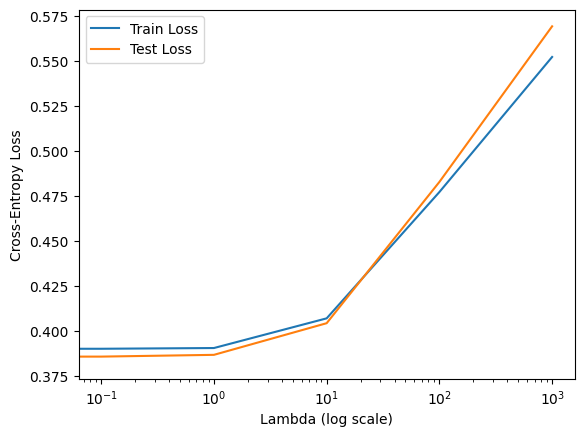

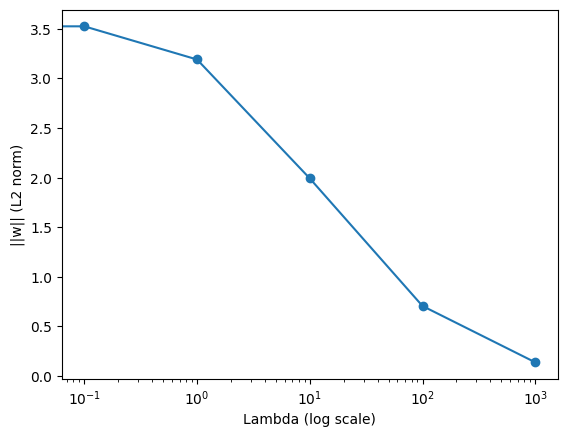

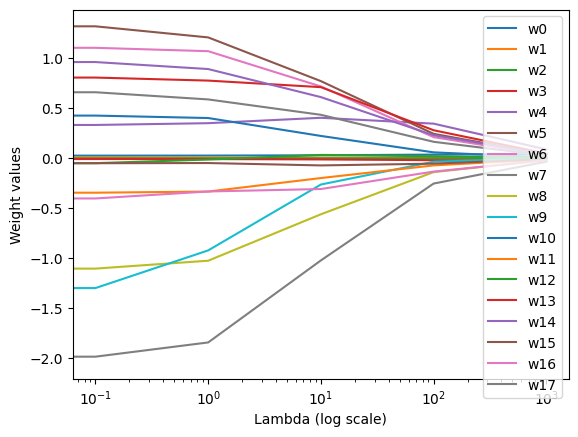

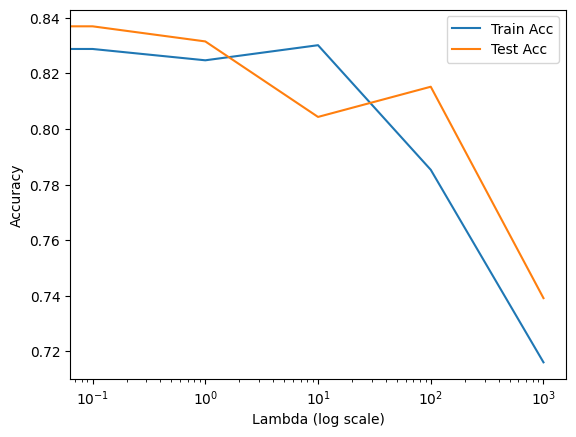

In [ ]:
# ==========================
# (d) Run logistic regression with L2 regularization, vary λ, plot results
# ==========================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy="mean")
X_encoded = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

lambdas = [0, 0.1, 1, 10, 100, 1000]
train_losses, test_losses, weight_norms, train_accs, test_accs, weights = [], [], [], [], [], []

for lam in lambdas:
    if lam == 0:
        # No regularization
        model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=500)
    else:
        # L2 regularization, note C = 1/λ
        model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=500)

    model.fit(X_train, y_train)
    y_pred_train = model.predict_proba(X_train)[:,1]
    y_pred_test = model.predict_proba(X_test)[:,1]

    train_losses.append(log_loss(y_train, y_pred_train))
    test_losses.append(log_loss(y_test, y_pred_test))
    weight_norms.append(np.linalg.norm(model.coef_))
    train_accs.append(accuracy_score(y_train, model.predict(X_train)))
    test_accs.append(accuracy_score(y_test, model.predict(X_test)))
    weights.append(model.coef_.flatten())

# Plot 1: Cross entropy loss
plt.figure()
plt.semilogx(lambdas, train_losses, label="Train Loss")
plt.semilogx(lambdas, test_losses, label="Test Loss")
plt.xlabel("Lambda (log scale)"); plt.ylabel("Cross-Entropy Loss")
plt.legend(); plt.show()

# Plot 2: L2 norm of weights
plt.figure()
plt.semilogx(lambdas, weight_norms, marker='o')
plt.xlabel("Lambda (log scale)"); plt.ylabel("||w|| (L2 norm)")
plt.show()

# Plot 3: Weight values
plt.figure()
weights = np.array(weights)
for i in range(weights.shape[1]):
    plt.semilogx(lambdas, weights[:, i], label=f"w{i}")
plt.xlabel("Lambda (log scale)"); plt.ylabel("Weight values")
plt.legend(); plt.show()

# Plot 4: Accuracy
plt.figure()
plt.semilogx(lambdas, train_accs, label="Train Acc")
plt.semilogx(lambdas, test_accs, label="Test Acc")
plt.xlabel("Lambda (log scale)"); plt.ylabel("Accuracy")
plt.legend(); plt.show()


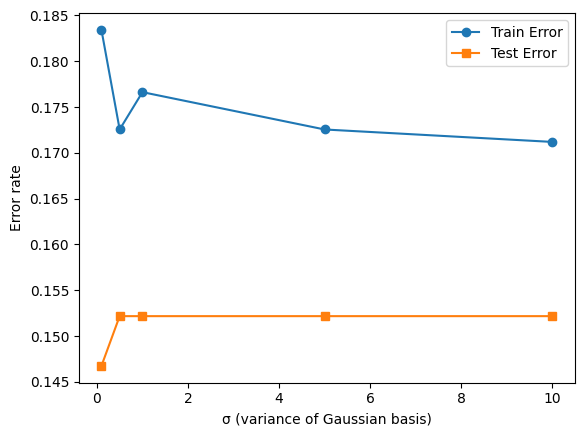

In [ ]:
# ==========================
# (e) Re-format data using Gaussian basis functions
# ==========================
from sklearn.preprocessing import FunctionTransformer

def gaussian_basis(x, mu, sigma):
    return np.exp(- (x - mu)**2 / (2 * sigma**2))

# Function to apply Gaussian basis expansion
def expand_with_gaussians(X, sigma):
    X_expanded = []
    for col in range(X.shape[1]):
        # Skip bias: basis functions only for features
        values = X[:, col]
        mus = np.linspace(-10, 10, 5)   # 5 evenly spaced means
        for mu in mus:
            X_expanded.append(gaussian_basis(values, mu, sigma))
    return np.vstack(X_expanded).T

# Try with different σ values
sigmas = [0.1, 0.5, 1, 5, 10]
X_train_arr, X_test_arr = X_train.values, X_test.values

train_errors, test_errors = [], []

for sigma in sigmas:
    X_train_g = expand_with_gaussians(X_train_arr, sigma)
    X_test_g = expand_with_gaussians(X_test_arr, sigma)

    model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=500)
    model.fit(X_train_g, y_train)

    train_pred = model.predict(X_train_g)
    test_pred = model.predict(X_test_g)

    train_errors.append(1 - accuracy_score(y_train, train_pred))
    test_errors.append(1 - accuracy_score(y_test, test_pred))

# Plot training vs testing error
plt.figure()
plt.plot(sigmas, train_errors, marker="o", label="Train Error")
plt.plot(sigmas, test_errors, marker="s", label="Test Error")
plt.xlabel("σ (variance of Gaussian basis)"); plt.ylabel("Error rate")
plt.legend(); plt.show()


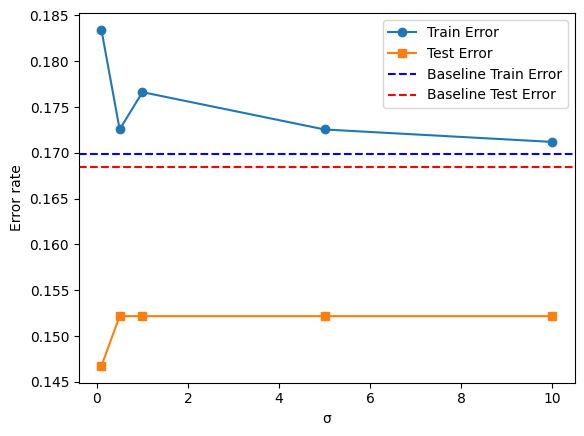

In [ ]:
# ==========================
# (f) Add baseline constant lines from part (c)
# ==========================
baseline_model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=500)
baseline_model.fit(X_train, y_train)
baseline_train_err = 1 - accuracy_score(y_train, baseline_model.predict(X_train))
baseline_test_err = 1 - accuracy_score(y_test, baseline_model.predict(X_test))

plt.figure()
plt.plot(sigmas, train_errors, marker="o", label="Train Error")
plt.plot(sigmas, test_errors, marker="s", label="Test Error")
plt.axhline(baseline_train_err, color="blue", linestyle="--", label="Baseline Train Error")
plt.axhline(baseline_test_err, color="red", linestyle="--", label="Baseline Test Error")
plt.xlabel("σ"); plt.ylabel("Error rate")
plt.legend(); plt.show()


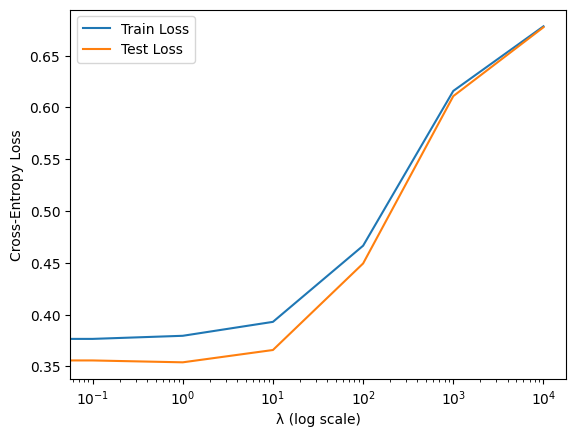

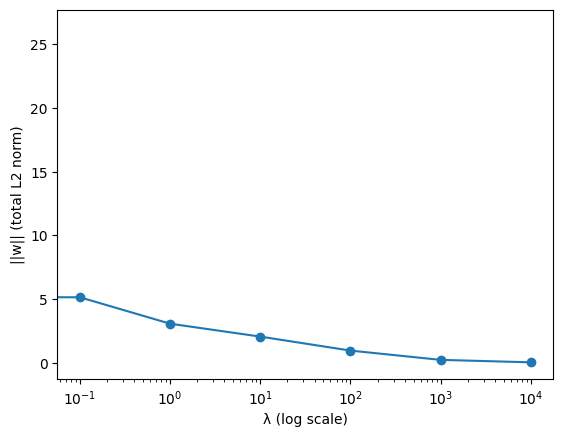

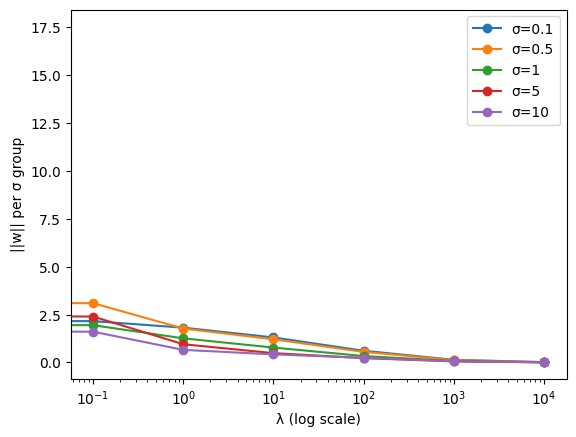

In [ ]:
# ==========================
# (g) Regularized regression with all Gaussian basis functions
# ==========================
lambdas = [0, 0.1, 1, 10, 100, 1000, 10000]
sigma_set = [0.1, 0.5, 1, 5, 10]

# Precompute expanded data for each σ
expanded_train = {s: expand_with_gaussians(X_train_arr, s) for s in sigma_set}
expanded_test = {s: expand_with_gaussians(X_test_arr, s) for s in sigma_set}

train_losses, test_losses, weight_norms = [], [], []
sigma_weight_norms = {s: [] for s in sigma_set}

for lam in lambdas:
    if lam == 0:
        model = LogisticRegression(penalty=None, solver="lbfgs", max_iter=500)
    else:
        model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=500)

    # Concatenate all basis sets together
    X_train_all = np.hstack([expanded_train[s] for s in sigma_set])
    X_test_all = np.hstack([expanded_test[s] for s in sigma_set])

    model.fit(X_train_all, y_train)

    y_pred_train = model.predict_proba(X_train_all)[:,1]
    y_pred_test = model.predict_proba(X_test_all)[:,1]

    train_losses.append(log_loss(y_train, y_pred_train))
    test_losses.append(log_loss(y_test, y_pred_test))
    weight_norms.append(np.linalg.norm(model.coef_))

    # Compute L2 norm for each σ group separately
    start = 0
    for s in sigma_set:
        size = expanded_train[s].shape[1]
        sigma_weight_norms[s].append(np.linalg.norm(model.coef_[:, start:start+size]))
        start += size

# Plot 1: Cross-entropy
plt.figure()
plt.semilogx(lambdas, train_losses, label="Train Loss")
plt.semilogx(lambdas, test_losses, label="Test Loss")
plt.xlabel("λ (log scale)"); plt.ylabel("Cross-Entropy Loss")
plt.legend(); plt.show()

# Plot 2: Overall weight norm
plt.figure()
plt.semilogx(lambdas, weight_norms, marker="o")
plt.xlabel("λ (log scale)"); plt.ylabel("||w|| (total L2 norm)")
plt.show()

# Plot 3: Per-σ weight norms
plt.figure()
for s in sigma_set:
    plt.semilogx(lambdas, sigma_weight_norms[s], marker="o", label=f"σ={s}")
plt.xlabel("λ (log scale)"); plt.ylabel("||w|| per σ group")
plt.legend(); plt.show()


h)If we want Gaussian basis functions that capture relationships between inputs (not just individual features), we need to design multivariate Gaussian basis functions that depend on two or more input variables at once.

Instead of
𝜙
(
𝑥
)
=
exp
⁡
(
−
(
𝑥
−
𝜇
)
2
2
𝜎
2
)
ϕ(x)=exp(−
2σ
2
(x−μ)
2
	​

),
we use

𝜙
(
𝑥
)
=
exp
⁡
(
−
(
𝑥
−
𝜇
)
𝑇
Σ
−
1
(
𝑥
−
𝜇
)
2
)
ϕ(x)=exp(−
2
(x−μ)
T
Σ
−1
(x−μ)
	​

).

This allows us to capture interactions and correlations between input variables.

Impact on bias-variance trade-off:

Using richer basis functions reduces bias (can model more complex relationships).

But it increases variance (model may overfit).

So we need regularization to balance bias and variance.

In [ ]:
# ==========================
# (h) Gaussian basis functions for input interactions
# ==========================
from itertools import combinations

def gaussian_interaction_basis(X, mus, sigma):
    """
    Construct interaction Gaussian features between feature pairs.
    """
    n_samples, n_features = X.shape
    expanded_features = []

    # For every feature pair, create Gaussian basis interactions
    for (i, j) in combinations(range(n_features), 2):
        xi, xj = X[:, i], X[:, j]
        for mu_i, mu_j in mus:
            phi = np.exp(-((xi - mu_i)**2 + (xj - mu_j)**2) / (2 * sigma**2))
            expanded_features.append(phi)

    return np.vstack(expanded_features).T

# Example: apply to first 2 features of training data
mus = [(0,0), (1,1), (2,2)]  # example centers
X_train_inter = gaussian_interaction_basis(X_train_arr[:, :2], mus, sigma=1.0)
X_test_inter = gaussian_interaction_basis(X_test_arr[:, :2], mus, sigma=1.0)

# Train model with interaction features
model = LogisticRegression(max_iter=500)
model.fit(X_train_inter, y_train)

print("Interaction Gaussian basis model test accuracy:",
      accuracy_score(y_test, model.predict(X_test_inter)))


Interaction Gaussian basis model test accuracy: 0.5543478260869565


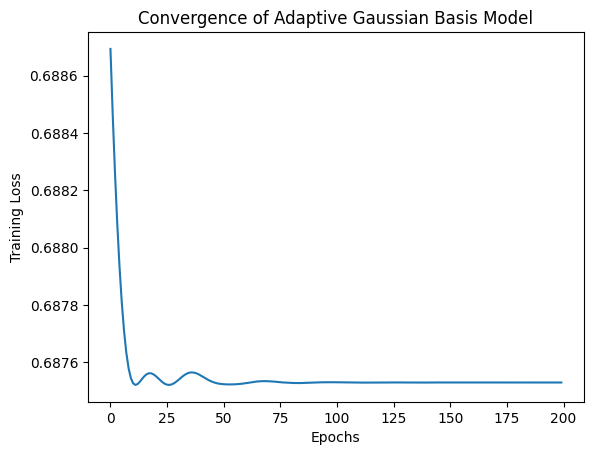

Final Training Loss: 0.6875293850898743
Test Accuracy: 0.5543478260869565
Learned centers (μ):
 [[ 6.29595071e-02 -2.15056018e-04  2.59737343e-01 -4.05445599e-06
   4.76460664e-05  6.37497976e-07  2.33843894e-04 -1.12798516e-05
   4.89912018e-05  2.65615508e-02  4.07175139e-06  9.62264910e-02
   9.74147394e-02  1.20045581e-06  1.46726801e-04 -1.77847445e-01
  -5.90820312e-02  3.76210983e-06]
 [ 1.50593442e-05 -1.33166816e-02  3.34499346e-05  5.91784556e-07
   5.47091361e-07  5.04951743e-07 -1.08202503e-05 -1.66179255e-01
  -1.33201301e+00 -9.37879533e-02 -1.36362451e-05 -3.25144697e-06
  -8.26943964e-02  9.36715980e-04 -2.18316883e-01  2.97079161e-02
   5.50529838e-01  8.05252194e-02]
 [-1.62834525e-01  3.13097805e-01 -3.19767906e-07  2.72974512e-06
  -5.60939126e-02  4.37194249e-05 -5.24568168e-05 -1.88933518e-02
  -1.91847084e-05  9.06507776e-05 -2.17192559e-04  3.64761104e-06
  -3.09766710e-06  4.27924961e-01 -2.43947580e-01 -4.62850148e-04
   7.51444325e-02  7.27984807e-05]
 [ 3.27

In [ ]:
# ==========================
# Adaptive Gaussian Basis Function Learning (Q1 i)
# ==========================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score

# Convert train/test data to torch tensors
X_train_torch = torch.tensor(X_train_arr, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test_arr, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define Adaptive Gaussian Model
class AdaptiveGaussianModel(nn.Module):
    def __init__(self, n_features, n_basis, sigma):
        super().__init__()
        self.mus = nn.Parameter(torch.randn(n_basis, n_features))  # learnable centers
        self.sigma = sigma                                        # fixed variance
        self.linear = nn.Linear(n_basis, 1)                       # learn weights w

    def forward(self, X):
        X_expanded = []
        for mu in self.mus:
            diff = X - mu
            phi = torch.exp(-torch.sum(diff**2, dim=1) / (2 * self.sigma**2))
            X_expanded.append(phi)
        Phi = torch.stack(X_expanded, dim=1)
        return torch.sigmoid(self.linear(Phi))  # logistic regression

# Initialize model
n_basis = 10   # number of Gaussian basis functions
sigma = 1.0    # fixed width
model = AdaptiveGaussianModel(n_features=X_train_torch.shape[1], n_basis=n_basis, sigma=sigma)

# Define optimizer with L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)  # L2 reg
loss_fn = nn.BCELoss()

# Training loop
epochs = 200
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = model(X_train_torch)
    loss = loss_fn(preds, y_train_torch)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Plot convergence
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Convergence of Adaptive Gaussian Basis Model")
plt.show()

# Evaluate on test data
with torch.no_grad():
    y_pred_test = (model(X_test_torch) > 0.5).float().numpy()
    acc = accuracy_score(y_test, y_pred_test)

print("Final Training Loss:", losses[-1])
print("Test Accuracy:", acc)
print("Learned centers (μ):\n", model.mus.detach().numpy())


j)1) What "converge" means here

When you run the iterative algorithm that optimizes both the basis centers
𝜇
𝑖
μ
i
	​

 and the weights
𝑤
w (e.g. by gradient-based updates), you are minimizing a differentiable objective

𝐽
(
𝑤
,
{
𝜇
𝑖
}
)
=
−
1
𝑁
∑
𝑛
=
1
𝑁
[
𝑦
𝑛
log
⁡
𝑝
𝑛
+
(
1
−
𝑦
𝑛
)
log
⁡
(
1
−
𝑝
𝑛
)
]
+
𝜆
2
∥
𝑤
∥
2
,
J(w,{μ
i
	​

})=−
N
1
	​

n=1
∑
N
	​

[y
n
	​

logp
n
	​

+(1−y
n
	​

)log(1−p
n
	​

)]+
2
λ
	​

∥w∥
2
,

with
𝑝
𝑛
=
𝜎
(
𝑤
0
+
∑
𝑖
𝑤
𝑖
𝜙
𝑖
(
𝑥
𝑛
;
𝜇
𝑖
)
)
p
n
	​

=σ(w
0
	​

+∑
i
	​

w
i
	​

ϕ
i
	​

(x
n
	​

;μ
i
	​

)). This objective is smooth (assuming
𝜙
ϕ is smooth), so common gradient methods produce a sequence of parameter vectors whose loss values usually decrease and — with appropriate step sizes — the gradients tend to zero. In optimization terminology that is convergence to a stationary point (critical point).

Convergence in practice depends on your optimizer and hyperparameters:

Gradient descent / SGD with a suitably small, possibly decaying, learning rate has theoretical guarantees to converge to a stationary point for smooth objectives.

Adaptive optimizers (Adam, RMSprop) typically converge faster in practice, but formal guarantees are weaker; still they usually reach a stationary point in practice.

Regularizers (L2 weight decay) and reasonable initialization help stability.

2) Local vs global optimality

The problem is convex in
𝑤
w if the basis functions
𝜙
𝑖
ϕ
i
	​

 and their centres
𝜇
𝑖
μ
i
	​

 are held fixed: logistic regression with L2 is convex in
𝑤
w and has a unique global minimizer for
𝑤
w.

The joint problem over
(
𝑤
,
{
𝜇
𝑖
}
)
(w,{μ
i
	​

}) is non-convex because
𝜙
𝑖
(
𝑥
;
𝜇
𝑖
)
ϕ
i
	​

(x;μ
i
	​

) depends nonlinearly on
𝜇
𝑖
μ
i
	​

. Nonconvexity implies:

The loss surface can contain many local minima, saddle points, and plateaus.

Gradient-based methods (or alternating minimization) cannot be guaranteed to find the global optimum in general.

At best you can expect to converge to a local minimum or saddle point (i.e., a stationary point).

So: the algorithm typically converges, but to a local solution (or stationary point), not necessarily the global optimum.

3) Practical consequences & diagnostics

Different random initializations for
𝜇
μ (or different seeds) often give different final solutions (different losses and generalization). This is a sign of multiple local minima.

Monitoring the training loss curve (and validation performance) helps detect:

Convergence (loss flattens),

Stalling at saddle points (loss decreases very slowly),

Overfitting (train loss low, val loss rising).

Use early stopping, weight decay (L2), and multiple restarts (choose best by validation) to mitigate local minima and overfitting.

4) Ways to improve chances of better solutions

Good initialization: e.g., initialize
𝜇
𝑖
μ
i
	​

 with k-means centers on data or by sampling representative points — often leads to better optima than random init.

Two-stage / alternating optimization: repeatedly (a) optimize
𝑤
w with fixed
𝜇
μ (convex, solved accurately), then (b) take a few gradient steps on
𝜇
μ. This tends to be more stable than joint updates.

Multiple restarts and pick the model with best validation loss.

Learning rate schedules, second-order-like methods, or advanced optimizers can help exit shallow local minima or saddle regions.

If global optimality is crucial, consider convex alternatives (kernel methods, Gaussian processes) that implicitly use infinitely many bases without optimizing centers.

5) Theoretical remark

For smooth non-convex objectives, standard results say gradient descent with sufficiently small constant step-size or with diminishing step-size will have gradient norms converge to zero (i.e., convergence to stationary points). They do not guarantee global minima.

Stronger global guarantees require extra structure (e.g., objective satisfying certain PL/Kurdyka–Łojasiewicz conditions), which the RBF-centers problem generally does not satisfy.

2 question
(a) Data preprocessing steps

Load dataset and inspect.

Handle missing values (imputation).

Encode categorical variables.

Scale numerical features.

Split into train/test.

(b) Linear Regression (and its versions)

Simple Linear Regression: predict chol from age.

Multiple Linear Regression: predict chol from all features.

Regularized versions: Ridge, Lasso regression.

(c) Logistic Regression (classification)

Predict target (1 = heart disease, 0 = no heart disease).

Compare accuracy, precision, recall.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Load dataset

data = pd.read_csv("heart_disease_uci (1).csv")

# Drop unnecessary columns
data = data.drop(columns=["id", "dataset"])

# Features and target for classification
X = data.drop(columns=["num"])
y = (data["num"] > 0).astype(int)


# Identify columns

numerical_cols = ["age", "trestbps", "chol", "thalch", "oldpeak"]
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Preprocessing pipeline

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # fill NaN with mean
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill NaN with most frequent
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


# LINEAR REGRESSION (Regression target: 'thalch')

X_lin = X.copy()
y_lin = data["thalch"]

# Remove rows where target is NaN
mask = ~y_lin.isna()
X_lin_clean = X_lin[mask]
y_lin_clean = y_lin[mask]

# Train-test split
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_lin_clean, y_lin_clean, test_size=0.2, random_state=42
)

# Linear Regression
linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
linear_model.fit(X_train_lin, y_train_lin)
y_pred_lin = linear_model.predict(X_test_lin)

print("=== Linear Regression Results ===")
print("MSE:", mean_squared_error(y_test_lin, y_pred_lin))
print("R2 Score:", r2_score(y_test_lin, y_pred_lin))

# Ridge Regression
ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])
ridge_model.fit(X_train_lin, y_train_lin)
print("Ridge Regression R2:", r2_score(y_test_lin, ridge_model.predict(X_test_lin)))

# Lasso Regression
lasso_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01))
])
lasso_model.fit(X_train_lin, y_train_lin)
print("Lasso Regression R2:", r2_score(y_test_lin, lasso_model.predict(X_test_lin)))


# LOGISTIC REGRESSION -
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
logistic_model.fit(X_train_log, y_train_log)
y_pred_log = logistic_model.predict(X_test_log)

print("\n=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test_log, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test_log, y_pred_log))
print("Classification Report:\n", classification_report(y_test_log, y_pred_log))


=== Linear Regression Results ===
MSE: 1.9167587238812877e-27
R2 Score: 1.0
Ridge Regression R2: 0.9999957812920788
Lasso Regression R2: 0.9999998501119797

=== Logistic Regression Results ===
Accuracy: 0.8097826086956522
Confusion Matrix:
 [[60 15]
 [20 89]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77        75
           1       0.86      0.82      0.84       109

    accuracy                           0.81       184
   macro avg       0.80      0.81      0.80       184
weighted avg       0.81      0.81      0.81       184

